<center><font size = "10"> Week 9 - Cells in Space  <center>
<center><font size = "8">Home work<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: Group 5
<br>Group member1: Camil Hamdane
<br>Group member2: Martim Simoes
<br>Group member3: Nathan Girard

In [1]:
# imports
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import neurom as nm
from neurom import view

In [76]:
# Methods definition
def shift_morphology(morph,shift):
    morph2 = morph.transform(lambda p: p + shift)
    return morph2
       
def center_morphology(morph):
    center = morph.soma.center.copy()
    return shift_morphology(morph,-center)

def rotate_morphology(morph,R):
    morph = morph.transform(lambda p: R.dot(p.T).T)
    return morph

def rotz_morphology(morph,theta):
    R = rotz(theta)
    return rotate_morphology(morph,R)

def rotz(theta):
    radtheta = theta * np.pi / 180.0 # in radians
    R = np.array([[np.cos(radtheta),-np.sin(radtheta),0],
                  [np.sin(radtheta),np.cos(radtheta),0],
                  [0,0,1]])
    return R
        
def align_morphology_Z(morph,axis):
    # Rotation matrix that aligns the Y axis [0,0,1] to an arbitrary vector b (other than Z or -Z)
    # From https://math.stackexchange.com/a/476311
    a = np.array([0,0,1])

    b = np.array(axis) # target axis
    b = b / np.linalg.norm(b) # make unit norm

    v = np.cross(a,b)     # a x b
    s = np.linalg.norm(v) # ||v|| = sin(theta)
    c = a.dot(b)          # a . b = cos(theta)

    # Skew-symmetric cross-product matrix
    V = np.zeros((3,3))
    V[0,1] = -v[2]
    V[1,0] =  v[2]
    V[0,2] =  v[1]
    V[2,0] = -v[1]
    V[1,2] = -v[0]
    V[2,1] =  v[0]

    # Rotation matrix
    R = np.diag((1.0,1.0,1.0))
    R += V
    R += V.dot(V) * (1.0 - c) / (s * s)

    # Test
    if not np.max(R.dot(a) - b) < 1E-12:
        raise ValueError('Matrix not good!')
    
    # Rotate morphology
    return rotate_morphology(morph,R)

# Poorman's plotting of morphologies
def plot_morphology(morph, plane = 'XY',somaOnly = False):
    colors_dict={nm.BASAL_DENDRITE:'red', 
            nm.APICAL_DENDRITE:'green',
            nm.AXON:'blue',
            nm.SOMA:'black'}
    
    colors_type = {"Inh" : "Blue", "Pyr" : "Red"}

    planes = { 'XY': [0,1], 'XZ': [0,2], 'YZ': [1,2], 'YX': [1,0], 'ZX': [2,0], 'ZY': [2,1] }
   
    if not somaOnly:
        for n in morph.neurites:
            pts = n.points[:,[0,1,2]]
            plt.scatter(pts[:,planes[plane][0]],pts[:,planes[plane][1]],s=1,c=colors_dict[n.type.value],marker='.')
    pts = morph.soma.center
    
    plt.scatter(pts[planes[plane][0]],pts[planes[plane][1]],c= colors_dict[nm.NeuriteType.soma.value],marker='D')
   
def plot_morphologies(morphlist,plane = 'XY',somaOnly = False):
    fig = plt.figure()
    fig.suptitle(plane)
    
    for i,m in enumerate(morphlist):
        plot_morphology(m, plane = plane, somaOnly = somaOnly)

def morph_get_all_points(morph):
    pts = morph.soma.center.copy()
    for n in morph.neurites:
        pts = np.vstack((pts,n.points[:,[0,1,2]]))
    return pts       

## Optional. Placing cells in a cubic volume

<font size='3'>Define a cubic volume with the following dimensions: x = (2000, 5000), y = (2000, 5000), z = (-1000, 2000). Place the five morphologies assigned to your group (used in week7) in random positions inside the cube. Visualize the cells in the cube in three different planes: xy, xz and yz. 

In [16]:
# Files path
files = ["Int_0" + str(i+1) + ".swc" for i in range(2)] + ["Pyr_0" + str(i+1) + ".swc" for i in range(3)]
files

['Int_01.swc', 'Int_02.swc', 'Pyr_01.swc', 'Pyr_02.swc', 'Pyr_03.swc']

In [20]:
rng = np.random.default_rng()

N = 5 # number of positions
volume = [[2000,5000],[2000,5000],[-1000,2000]] # volume bounds [um]

# get positions in required ranges
pos = rng.random((N,3)) # in [0,1)
for i,x in enumerate(volume):
    pos[:,i] = (x[1] - x[0]) * pos[:,i] + x[0]

print("Position of the cube in space :")
pos # print positions

Position of the cube in space :


array([[3858.93049728, 4750.57263876,  541.73225181],
       [3504.5292934 , 4834.1937571 , 1134.38068223],
       [4793.6440533 , 3832.51407423, -623.35877629],
       [3849.77367983, 3600.71654436,  927.07508594],
       [3803.91005551, 3297.42872065, -345.16572911]])

In [32]:
morphs = [nm.load_morphology(x) for x in files]

# place all morphologies
for i,m in enumerate(morphs):
    m=center_morphology(m)
    m=shift_morphology(m,pos[i])
    morphs[i]=m

print("Soma centers of the morph files :")
for i in range(len(morphs)):
    print(files[i][:-4] + ":")
    print(morphs[i].soma.center)

Soma centers of the morph files :
Int_01:
[3858.9304  4750.5728   541.73224]
Int_02:
[3504.5293 4834.194  1134.3807]
Pyr_01:
[4793.644   3832.5142  -623.35876]
Pyr_02:
[3849.7737 3600.7166  927.0751]
Pyr_03:
[3803.9102  3297.4287  -345.16574]


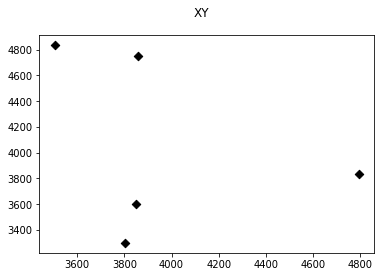

In [33]:
plot_morphologies(morphs,somaOnly = True)

Text(0, 0.5, 'y')

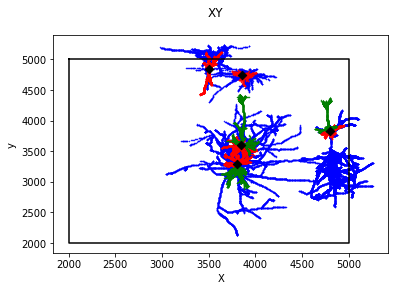

In [59]:
# XY plane
plot_morphologies(morphs, somaOnly=False)
# Plot volume containing somas
plt.plot((volume[0][0],volume[0][1],volume[0][1],volume[0][0],volume[0][0]),
         (volume[1][1],volume[1][1],volume[1][0],volume[1][0],volume[1][1]),c='black')
plt.xlabel('X')
plt.ylabel('y')

Text(0, 0.5, 'Z')

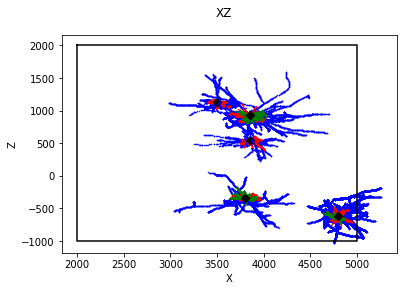

In [43]:
# XZ plane
plot_morphologies(morphs, plane = "XZ", somaOnly=False)
# Plot volume containing somas
plt.plot((volume[0][0],volume[0][1],volume[0][1],volume[0][0],volume[0][0]),
         (volume[2][1],volume[2][1],volume[2][0],volume[2][0],volume[2][1]),c='black')
plt.xlabel('X')
plt.ylabel('Z')

Text(0, 0.5, 'Z')

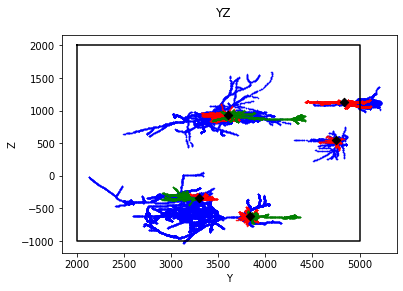

In [45]:
# YZ plane
plot_morphologies(morphs, plane = "YZ", somaOnly=False)
# Plot volume containing somas
plt.plot((volume[1][0],volume[1][1],volume[1][1],volume[1][0],volume[0][0]),
         (volume[2][1],volume[2][1],volume[2][0],volume[2][0],volume[2][1]),c='black')
plt.xlabel('Y')
plt.ylabel('Z')

## Ex2. 3D Rotaion around a vector

<font size='3'>To start of, compute a 2D rotation along the y axis on the inhibitory cells from your data set (week 7), the rotation angles should be: -90°, -180° and -270°. Plot the results in xy plane. Now compute a 3D rotation to align your pyramidal cells' z axis with the vector (3,4,5). [1.5 pts]
    
### 2.1 Rotation around Z axis of the inhibitory cells

In [70]:
Inh_cells = morphs[:-3]
angles = [-90, -180, -270]

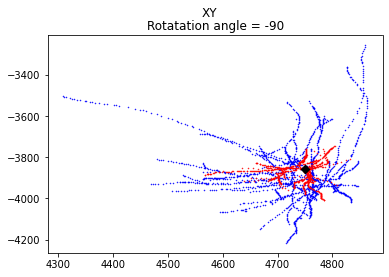

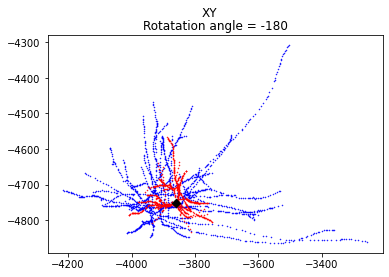

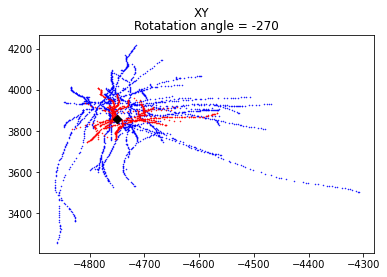

In [73]:
# Int_01 cell
for i in range(len(angles)):
    morph_tmp = rotz_morphology(morphs[0], angles[i])
    plot_morphologies([morph_tmp])
    plt.title("Rotatation angle = {}".format(angles[i]))

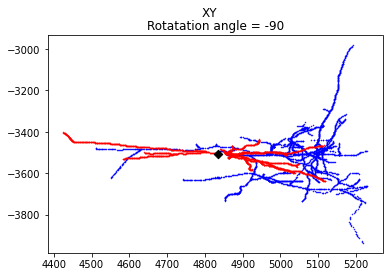

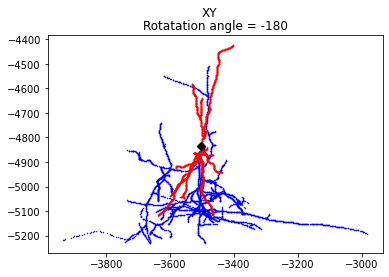

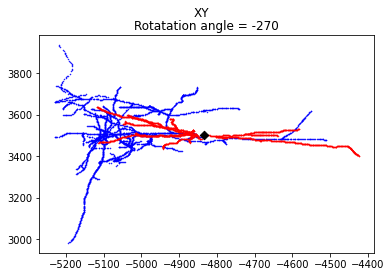

In [74]:
# Int_02 cell
for i in range(len(angles)):
    morph_tmp = rotz_morphology(morphs[1], angles[i])
    plot_morphologies([morph_tmp])
    plt.title("Rotatation angle = {}".format(angles[i]))

### 2.2 3D rotation to align Pyramidal cells along Z-axis

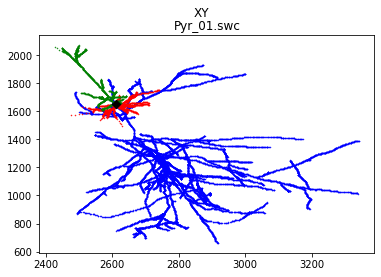

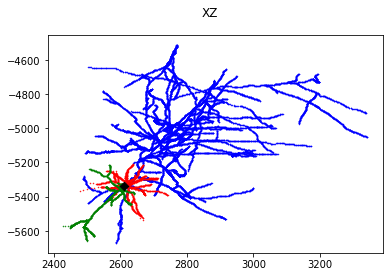

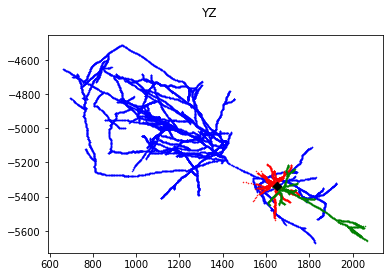

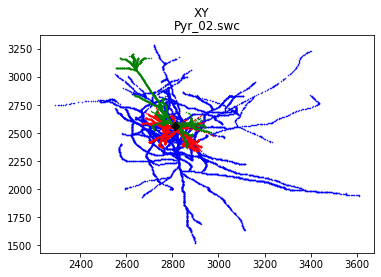

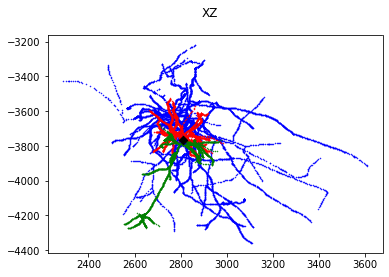

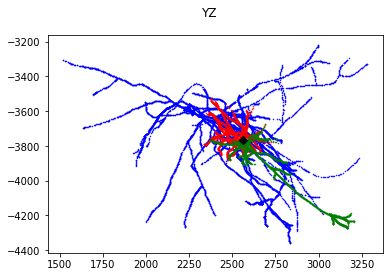

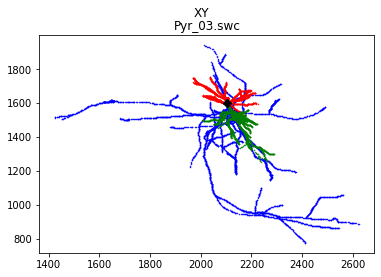

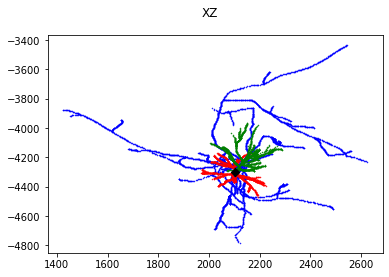

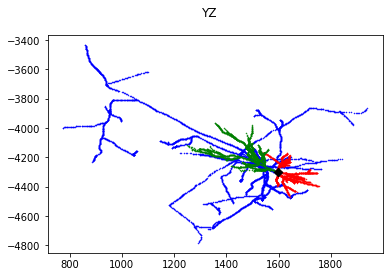

In [81]:
# Pyr_01 cell
for i in range(3):
    morph_tmp = align_morphology_Z(morphs[i+2],[1,1,1])
    plot_morphologies([morph_tmp],plane = 'XY')
    plt.title(files[i+2])
    
    plot_morphologies([morph_tmp],plane = 'XZ')
    plot_morphologies([morph_tmp],plane = 'YZ')

## Ex3. Placing cells in a volume


<font size='3'> Define a hexagonal or cylindrical column of the same dimensions as in https://www.cell.com/fulltext/S0092-8674(15)01191-5  
<span>
<font size='3'>
Chose 5 points inside the volume to place your cells in, as follows: 
- inhibitory cells placed in randomly, witn no rotation or orientation rules applied
- pyramidal cells placed in the region of the volume corresponding to layers II-VI, with two of the cells with their apical dendrites facing up and one with its apical dendrites facing down
</span>

<font size='3'>Align the pyramidal cells' y axes with the column's vertical axis (larger values on the y axis corresponding to positions closer to the surface of the column). Plot the results in 2D, in all three planes, to show proper orientation. Also include a 3D plot of the column with all five cells placed in, inhibitory cells displayed in red and pyramidal ones in blue, magenta and cyan, respectively.  [2 pts]

In [89]:
N = 5 # number of positions
center = [100,100,100] # um
outer_radius = 210 # um
inner_radius = np.sqrt(3)/2 * outer_radius
height = 2082 # um
layers_thicknesses = [165, 149, 353, 190, 525, 700] # um

# get positions in hexagonal column
# NOTE: we must use normal sampling to get uniform points
pos = np.random.randn(3, N)
pos /= np.linalg.norm(pos, axis = 0)
pos = pos.T

# Save normals
normals = pos.copy()

# Scale and translate
# PC cells
# layers II - VI : [-1041, + 876]
pos[2:, 0:2] *= np.random.uniform(inner_radius, outer_radius) # x and y axis
pos[2:, 2] *= ((height - layers_thicknesses[0]) / 2) - (layers_thicknesses[0] / 2)

#Inh cells 
pos[:1, 0:2] *= radius #x, y axis
pos[:1, 2] *= (height / 2)

pos += center

pos

array([[ 237.78067269,  129.92512591, -671.48454117],
       [ 100.99671968,  100.0651007 ,  100.04808099],
       [ 185.42225465,  211.179369  ,  676.17474889],
       [  63.90769029,  131.59188233, -746.41480306],
       [ 134.83308555,  260.41544062, -312.96731989]])

In [90]:
# place all morphologies
for i,m in enumerate(morphs):
    m=center_morphology(m)
    m=align_morphology_Y(m,normals[i])
    m=shift_morphology(m,pos[i])
    if i == len(morphs):
        rotz_morphology(m, 180)
    morphs[i]=m

[x.soma.center for x in morphs] # print centers

[array([ 237.78067,  129.92513, -671.48456], dtype=float32),
 array([100.99672, 100.0651 , 100.04808], dtype=float32),
 array([185.42226, 211.17937, 676.17474], dtype=float32),
 array([  63.907692,  131.59189 , -746.4148  ], dtype=float32),
 array([ 134.83308,  260.41544, -312.96732], dtype=float32)]

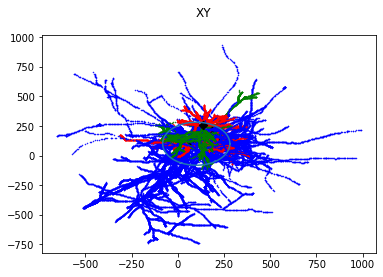

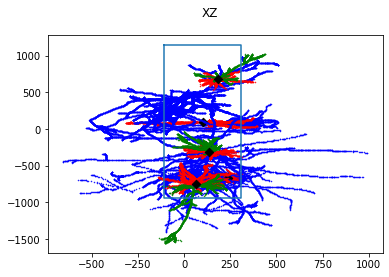

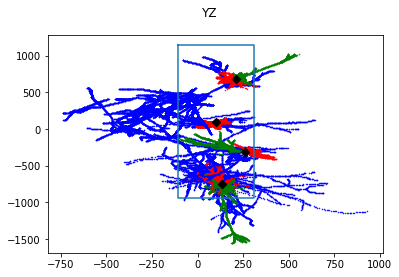

In [104]:
# Visualize in all three planes
from matplotlib.patches import RegularPolygon

# XY plane
plot_morphologies(morphs, plane = 'XY')
angles = np.linspace(0, 2.0 * np.pi, 360)
xp = center[0] + inner_radius * (2* np.cos(angles%15) - np.cos(angles % 30)) # find a way to draw hexagon
yp = center[1] + inner_radius * (2* np.sin(angles%15) - np.sin(angles % 30)) # same but with y coordinates
plt.plot(xp,yp)

# XZ plane
volume = [[center[0] - outer_radius, center[0] + outer_radius], 
          [center[2] - (height / 2), center[2] + (height / 2)]] # volume bounds of XZ [um]
plot_morphologies(morphs, plane = 'XZ')
plt.plot((volume[0][0],volume[0][1],volume[0][1],volume[0][0],volume[0][0]),
         (volume[1][1],volume[1][1],volume[1][0],volume[1][0],volume[1][1]))
plt.show()

# YZ plane
volume = [[center[1] - outer_radius, center[1] + outer_radius],
          [center[2] - (height / 2), center[2] + (height / 2)]] # volume bounds of XZ [um]
plot_morphologies(morphs,plane = 'YZ')
plt.plot((volume[0][0],volume[0][1],volume[0][1],volume[0][0],volume[0][0]),
         (volume[1][1],volume[1][1],volume[1][0],volume[1][0],volume[1][1]))
plt.show()

## Ex4. Synaptic Pruning

<font size='3'> Your task is to implement the synapse pruning algorithm from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4597796/ using the number of appositions for a particular EXC-INH connection type provided below, bouton density of 0.2 and a 10^5 scaling factor for calculating the post-pruning bouton density.  After each step, plot a histogram of synapses per connection. At the end, represent the results with two histograms, one histogram of synapses per active connection, and one of synapses per reserve connection. Please note that as the data are made up, you should not expect to see the same results as in the paper. [2.5 pts]

In [ ]:
import numpy as np

appositions = np.concatenate((np.ones(6300),2*np.ones(5400),3*np.ones(4750),4*np.ones(3800),5*np.ones(3000),\
                              6*np.ones(2500),7*np.ones(2000),8*np.ones(1700),9*np.ones(1600),10*np.ones(1500),\
                              11*np.ones(1200),12*np.ones(1000),13*np.ones(800),14*np.ones(800),15*np.ones(700),\
                              16*np.ones(600),17*np.ones(550),18*np.ones(500),19*np.ones(450),20*np.ones(400)))

appositions = appositions.astype(int)